In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Libraries

In [2]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Exploration

In [3]:
# read the dataset
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv('/kaggle/input/titanic/test.csv')

train_copy = train.copy()
test_copy = test.copy()

In [4]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
print(f"train shape: {train.shape}\ntest shape: {test.shape}") 

train shape: (891, 12)
test shape: (418, 11)


In [8]:
# It's just an iterative ID, we can drop it
train['PassengerId'].nunique() == train.shape[0]

True

In [9]:
# Survived distribution
train['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [10]:
# Pclass distribution
train['Pclass'].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [11]:
# Name
train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [12]:
# Counting all the words in the column

def preprocess_text(df, column):
    """
    This function preprocesses the data given the column on which
    preprocessing is to be applied
    """
    # Define the tokenization function
    def tokenize(column):
        # Use the regular expression pattern for tokenization
        pattern = r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?"
        tokens = re.findall(pattern, column.lower())  # Convert to lowercase
        return tokens

    # Apply the tokenization function to the input column
    df['tokens'] = df[column].apply(tokenize)

    # Calculate document frequency (DF) for each word in the document collection
    document_frequency = Counter()
    for tokens in df['tokens']:
        document_frequency.update(set(tokens))  # Using set to count each word only once per document

    # Convert the document frequency counter to a dictionary
    document_frequency_dict = dict(document_frequency)

    # dropping the column
    df.drop('tokens', axis=1, inplace=True)
    return document_frequency_dict

# Unpack the tuple returned by preprocess_text
document_frequency_dict = preprocess_text(train, "Name")
document_frequency_dict = dict(sorted(document_frequency_dict.items(), key=lambda item: item[1], reverse=True))
document_frequency_dict


{'mr': 518,
 'miss': 182,
 'mrs': 129,
 'william': 63,
 'john': 44,
 'master': 40,
 'henry': 34,
 'james': 24,
 'charles': 24,
 'george': 23,
 'thomas': 22,
 'mary': 20,
 'edward': 18,
 'anna': 17,
 'joseph': 16,
 'elizabeth': 15,
 'johan': 15,
 'frederick': 15,
 'richard': 14,
 'samuel': 13,
 'arthur': 13,
 'margaret': 12,
 'alfred': 12,
 'maria': 11,
 'alexander': 11,
 'peter': 11,
 'robert': 10,
 'jr': 10,
 'leonard': 9,
 'andersson': 9,
 'ernest': 9,
 'karl': 9,
 'j': 8,
 'annie': 8,
 'h': 8,
 'albert': 8,
 'martin': 8,
 'victor': 8,
 'alice': 8,
 'helen': 7,
 'frank': 7,
 'david': 7,
 'sage': 7,
 'dr': 7,
 'johnson': 6,
 'e': 6,
 'marie': 6,
 'panula': 6,
 'goodwin': 6,
 'skoog': 6,
 'francis': 6,
 'elias': 6,
 'sofia': 6,
 'rev': 6,
 'edith': 6,
 'van': 6,
 'harry': 6,
 'kate': 6,
 'carter': 6,
 'de': 6,
 'catherine': 6,
 'harris': 5,
 'florence': 5,
 'rice': 5,
 'williams': 5,
 'augusta': 5,
 'ellen': 5,
 'anne': 5,
 'hansen': 5,
 'bertha': 5,
 'gustafsson': 5,
 'ford': 5,
 'dan

In [13]:
# Mr,Miss,Mrs because we already have a gender column
document_frequency_dict.pop('mr')
document_frequency_dict.pop('miss')
document_frequency_dict.pop('mrs')

129

In [14]:
# how long is the dictionary now
len(document_frequency_dict)

1521

The dictionary, encompassing all words from the 'Name' column, contains 1,521 unique entries, surpassing the total of 891 rows. With 'William' being the most frequent name at 63 occurrences, the data exhibits a varied distribution of passenger names. Consequently, this disparity suggests that the 'Name' column alone may not provide reliable insights into its correlation with the 'Survival' column.

In [15]:
# descriptive statistics for age
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [16]:
# Making eight groups from 0-80 of age
train['Age'] = pd.cut(train['Age'], bins=8)

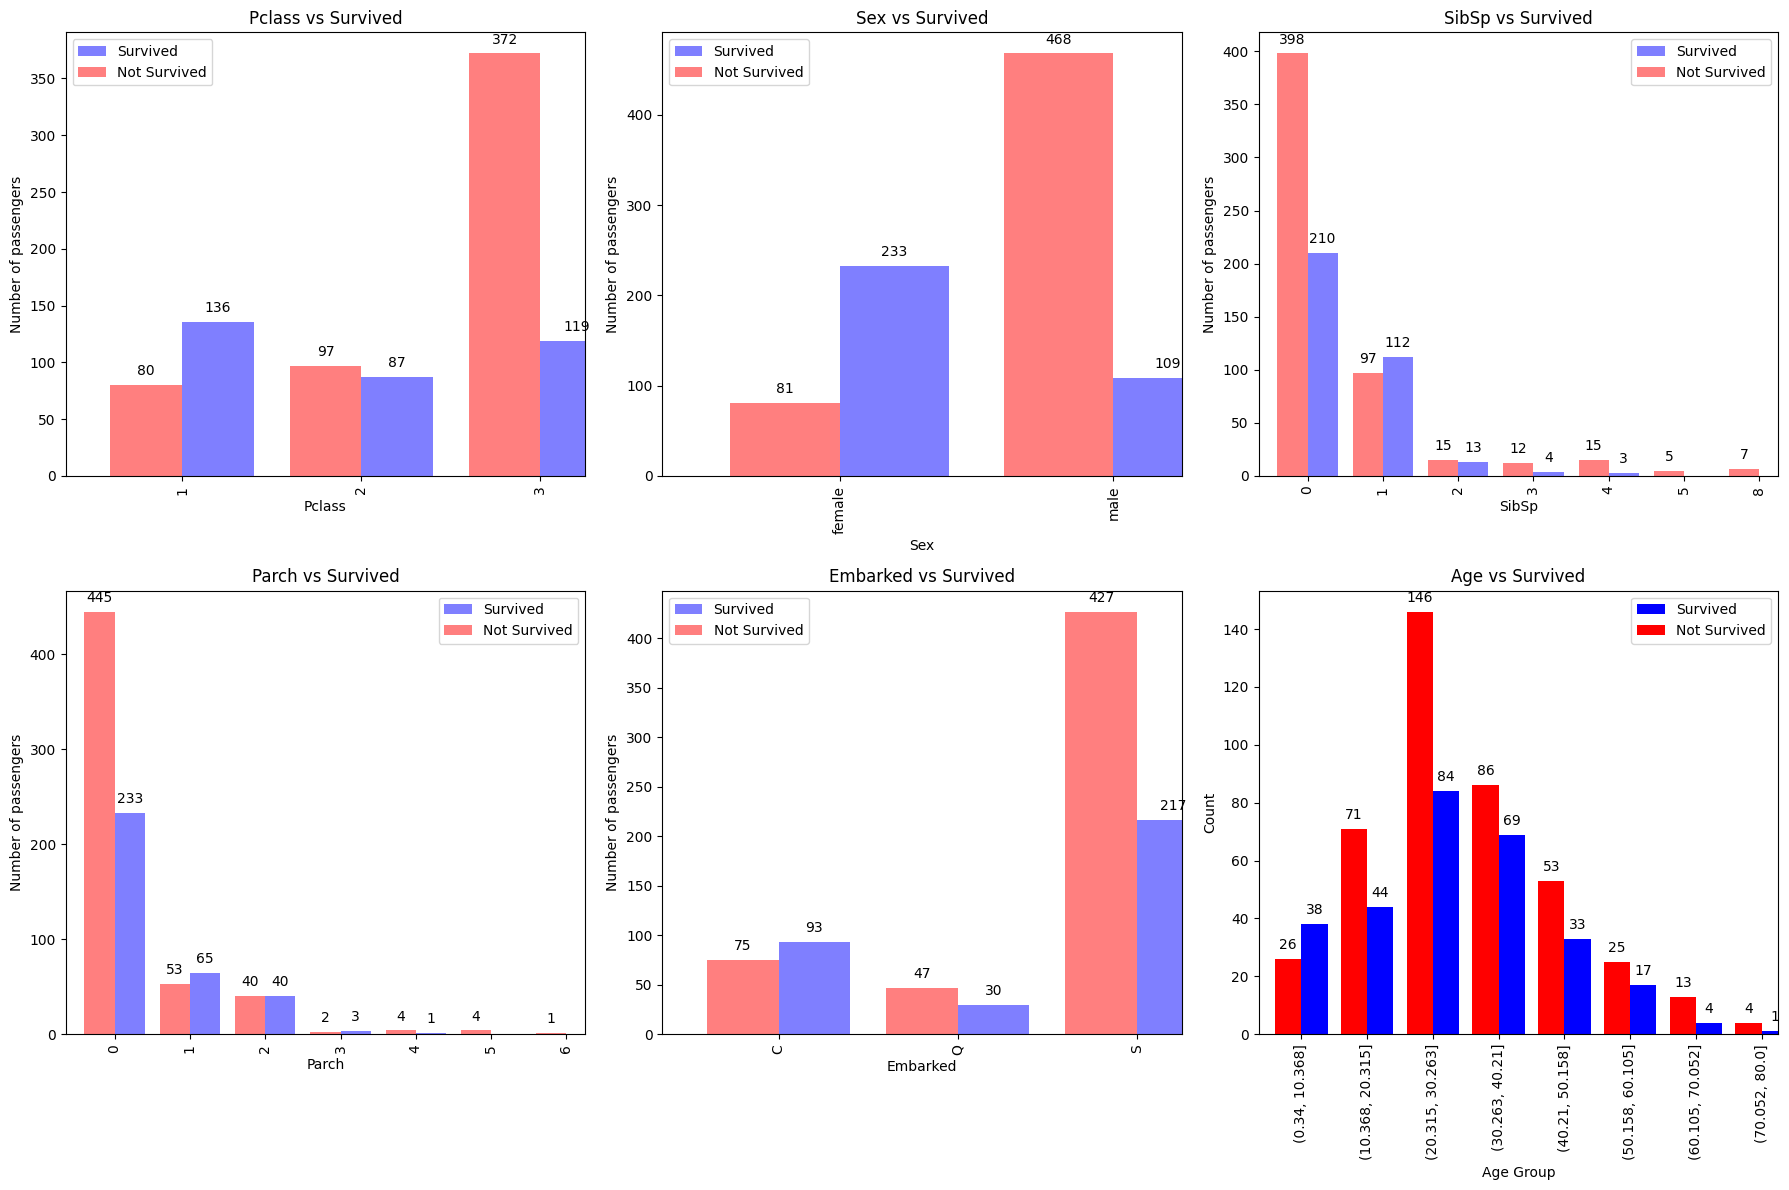

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'train' is your DataFrame and it's already loaded

survived = train[train['Survived'] == 1]
not_survived = train[train['Survived'] == 0]

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  # Adjust as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

# List of columns to plot
columns = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Age']

# Loop through the columns and create each subplot
for i, col in enumerate(columns):
    if col != 'Age':
        # Get the counts for other columns
        survived_counts = survived[col].value_counts().sort_index()
        not_survived_counts = not_survived[col].value_counts().sort_index()

        # Plot for other columns
        survived_counts.plot(kind='bar', alpha=0.5, color='blue', label='Survived', ax=axes[i], position=0, width=0.4)
        not_survived_counts.plot(kind='bar', alpha=0.5, color='red', label='Not Survived', ax=axes[i], position=1, width=0.4)

        # Set titles and labels
        axes[i].set_title(f'{col} vs Survived')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Number of passengers')
        axes[i].legend()

        # Annotate bars
        for p in axes[i].patches:
            axes[i].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    else:
        # Special handling for 'Age' column
        age_survived_count = train[train['Survived'] == 1]['Age'].value_counts().sort_index()
        age_not_survived_count = train[train['Survived'] == 0]['Age'].value_counts().sort_index()

        # Plot for 'Age'
        age_survived_count.plot(kind='bar', color='blue', position=0, width=0.4, label='Survived', ax=axes[i])
        age_not_survived_count.plot(kind='bar', color='red', position=1, width=0.4, label='Not Survived', ax=axes[i])

        # Set titles and labels for 'Age'
        axes[i].set_title('Age vs Survived')
        axes[i].set_xlabel('Age Group')
        axes[i].set_ylabel('Count')
        axes[i].legend()

        # Annotate bars for 'Age'
        for p in axes[i].patches:
            axes[i].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Adjust layout
plt.tight_layout()

# Hide the last (empty) subplot if the number of plots is less than the grid size
if len(columns) < len(axes):
    for i in range(len(columns), len(axes)):
        fig.delaxes(axes[i])

plt.show()


- First class survival ratio is more.
- Female ratio survival is more.
- SibSp & Parch have a lot of variation and outliers. We can perhaps combine these two columns as total relatives.
- Pclass, Sex and Embarked ratios tells us a lot about who is more likely to survive.
- Age follows a normal distribution

In [18]:
# extra feature, lets see if the patterns are clearer now than SibSp & Parch
train['relatives'] = train['SibSp'] + train['Parch']

In [19]:
train['relatives'].value_counts()

relatives
0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: count, dtype: int64

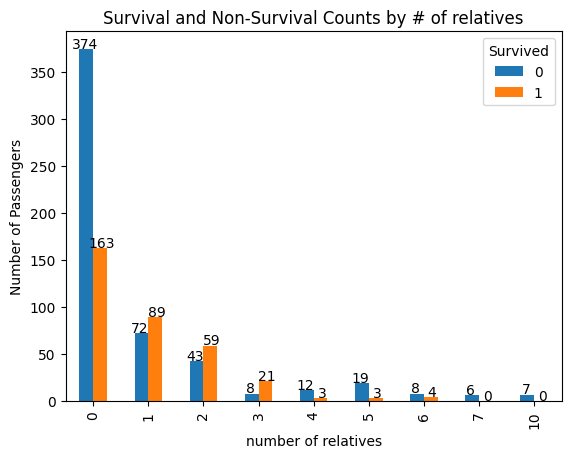

In [20]:
# Group by 'Cabin' and calculate the sum of 'Survived' for each group
survival_data = train.groupby('relatives')['Survived'].value_counts().unstack()
survival_data = survival_data.fillna(0)  # Fill NaN with 0

# Plotting
survival_data.plot(kind='bar')
plt.xlabel('number of relatives')
plt.ylabel('Number of Passengers')
plt.title('Survival and Non-Survival Counts by # of relatives')

# Adding counts on top of each bar
for i, (index, row) in enumerate(survival_data.iterrows()):
    plt.text(i - 0.15, row[0] + 1, int(row[0]), ha='center')
    plt.text(i + 0.15, row[1] + 1, int(row[1]), ha='center')

plt.show()

In [21]:
# are there any repetitive patterns?
train['Ticket'].value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

In [22]:
# extraching alphabets from tickets to see if there are any patterns?
train['Ticket'] = train['Ticket'].str.replace('[^A-Za-z]', '', regex=True)
train['Ticket'].value_counts()

Ticket
             661
PC            60
CA            41
A             28
STONO         18
SOTONOQ       15
WC            10
SCPARIS        7
SOC            6
C              5
FCC            5
LINE           4
SCParis        4
WEP            3
PP             3
SOPP           3
SOTONO         2
SCAH           2
SWPP           2
PPP            2
FC             1
SCAHBasle      1
AS             1
SOP            1
SC             1
SCOW           1
Fa             1
SP             1
SCA            1
CASOTON        1
Name: count, dtype: int64

- Most of the tickets are random numbers.
- Confirm by this line while commenting the alphabets extraction one: train['Ticket'] = train['Ticket'].str.replace('[^\d]', '', regex=True)
- We can drop ticket attribute.

In [23]:
# descriptive stats for fare
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

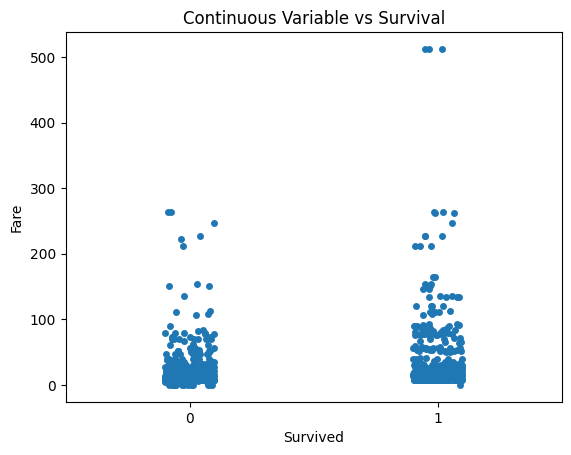

In [24]:
# Does Fare effect survival? we expect distribution of fare in survival is higher than those who didn't survived
sns.stripplot(x='Survived', y='Fare', data=train, jitter=True)
plt.title('Continuous Variable vs Survival')
plt.show()

- Distributions is almost the same with exception of some outliers.

In [25]:
# how many outliers are there?
# Calculate Q1, Q3, and IQR
Q1 = train['Fare'].quantile(0.25)
Q3 = train['Fare'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = train[(train['Fare'] < lower_bound) | (train['Fare'] > upper_bound)]
print("Number of outliers:", len(outliers))
print("ratio of outliers to total data:", len(outliers)/len(train))

Number of outliers: 116
ratio of outliers to total data: 0.13019079685746351


In [26]:
# Average fares for cabin alphabets

# Extract all alphabetic characters
alphabets = train['Cabin'].str.extractall('([A-Za-z])')[0]

# Flatten to a Series
alphabets = alphabets.dropna().unique()

# Convert to a set to find unique values
unique_alphabets = set(alphabets)

# Modified function to take an alphabet as an argument
def contains_pattern_once(text, alphabet):
    if pd.isna(text):
        return False
    # Construct the regular expression pattern dynamically
    pattern = r'\b' + re.escape(alphabet) + r'[A-Za-z0-9]*\b'
    # Find all occurrences of the pattern
    matches = re.findall(pattern, text)
    # Check if the pattern occurs exactly once
    return len(matches) == 1

average_fares = {}

# Loop through each unique alphabet and calculate the mean fare
for i in unique_alphabets:
    mean_fare = train[train['Cabin'].apply(lambda x: contains_pattern_once(x, i))]['Fare'].mean()
    average_fares[i] = mean_fare

average_fares

{'F': 18.69679230769231,
 'G': 11.039285714285715,
 'A': 39.623886666666664,
 'B': 89.95694722222223,
 'T': 35.5,
 'D': 57.053521875,
 'C': 81.85792352941176,
 'E': 45.3094696969697}

In [27]:
# many missing values
train['Cabin'].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

In [28]:
# Filter the DataFrame for rows where 'Cabin' is NaN
missing_cabin_indices = train[train['Cabin'].isna()].index

In [29]:
# Sort the DataFrame by 'Fare'
train_sorted = train.sort_values(by='Fare')

# Function to find the nearest non-missing Cabin with the same Embarked and Pclass
def find_nearest_cabin(fare, cabin, embarked, pclass, sorted_df):
    if pd.notna(cabin):
        return cabin
    else:
        # Filter the DataFrame for the same Embarked and Pclass
        same_embarked_pclass = sorted_df[(sorted_df['Embarked'] == embarked) & (sorted_df['Pclass'] == pclass)]

        # If there are no rows with the same Embarked and Pclass, return the original cabin value
        if same_embarked_pclass.empty:
            return cabin

        # Compute the absolute difference with all fares in the filtered DataFrame
        fare_diff = same_embarked_pclass['Fare'].apply(lambda x: abs(x - fare))
        # Find the index of the minimum difference where Cabin is not NaN
        nearest_index = fare_diff[same_embarked_pclass['Cabin'].notna()].idxmin()
        # Return the Cabin at the nearest index
        return same_embarked_pclass.loc[nearest_index, 'Cabin']

# Apply the function to each row
train['Cabin'] = train.apply(lambda row: find_nearest_cabin(row['Fare'], row['Cabin'], row['Embarked'], row['Pclass'], train_sorted), axis=1)

In [30]:
# Regular expression pattern
pattern = r'\b[A-Za-z0-9]+\b'

# Function to count regex matches or return NaN
def count_matches_or_nan(text):
    if pd.isna(text):
        return pd.NA
    else:
        return len(re.findall(pattern, text))

# Count the number of regex matches in each row of the Cabin column
x = train['Cabin'].apply(count_matches_or_nan)

In [31]:
x.value_counts() 

Cabin
1    724
2    159
3      6
4      2
Name: count, dtype: int64

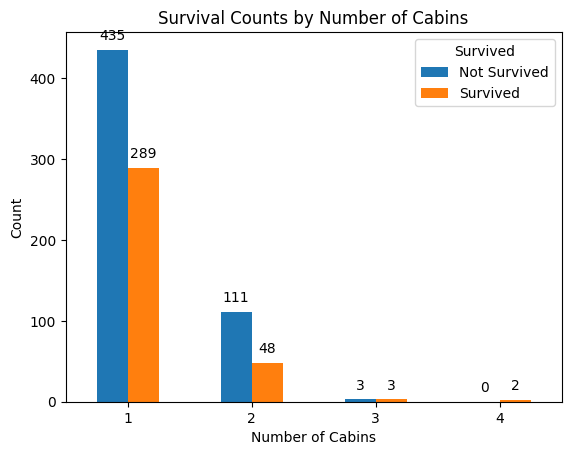

In [32]:
# Create a crosstab of number_of_cabins and Survived
cabin_survived_ct = pd.crosstab(x, train['Survived'])

# Plot
ax = cabin_survived_ct.plot(kind='bar', stacked=False)

plt.title('Survival Counts by Number of Cabins')
plt.xlabel('Number of Cabins')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotates X-axis labels for readability
plt.legend(title='Survived', labels=['Not Survived', 'Survived'])

# Annotate bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


In [33]:
def count_cabin_types(df, cabin_column):
    cabin_counts = {}
    for cabin in df[cabin_column]:
        if pd.notna(cabin):
            for char in cabin:
                if char.isalpha():
                    if char in cabin_counts:
                        cabin_counts[char] += 1
                    else:
                        cabin_counts[char] = 1
    return cabin_counts

cabin_counts = count_cabin_types(train, 'Cabin')
print(cabin_counts)

{'F': 345, 'G': 205, 'C': 95, 'E': 275, 'D': 51, 'A': 20, 'B': 76, 'T': 1}


In [34]:
train['Cabin'].value_counts()

Cabin
E10      135
G6       127
F G73     77
F38       72
F E69     66
        ... 
E63        1
E12        1
D21        1
E38        1
C148       1
Name: count, Length: 147, dtype: int64

In [35]:
train['Cabin'] = train['Cabin'].str.replace('[^A-Za-z ]', '', regex=True)

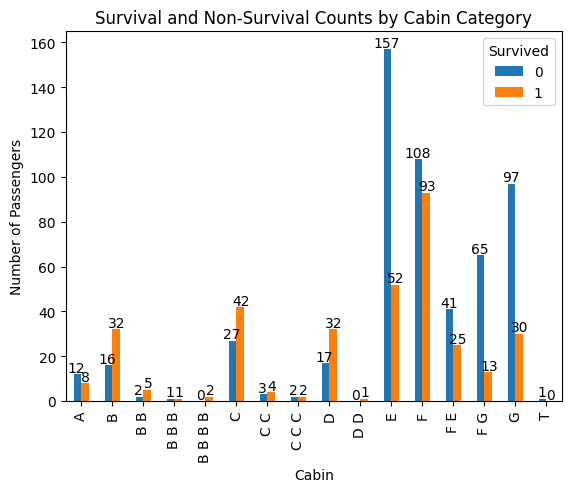

In [36]:
# Assuming 'df' is your DataFrame
# Group by 'Cabin' and calculate the sum of 'Survived' for each group
survival_data = train.groupby('Cabin')['Survived'].value_counts().unstack()
survival_data = survival_data.fillna(0)  # Fill NaN with 0

# Plotting
survival_data.plot(kind='bar')
plt.xlabel('Cabin')
plt.ylabel('Number of Passengers')
plt.title('Survival and Non-Survival Counts by Cabin Category')

# Adding counts on top of each bar
for i, (index, row) in enumerate(survival_data.iterrows()):
    plt.text(i - 0.15, row[0] + 1, int(row[0]), ha='center')
    plt.text(i + 0.15, row[1] + 1, int(row[1]), ha='center')

plt.show()